# 1.Setup:

###a. Install & Load Pkgs

In [ ]:
!pip install anytree
!pip install python-louvain

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cvxpy as cp
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import copy
import torch
import os
from anytree import Node, RenderTree, LevelOrderGroupIter, LevelOrderIter, PreOrderIter
from collections import Counter
from anytree.exporter import DotExporter
from community import community_louvain
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from itertools import count
from scipy import stats
%matplotlib inline

###b. Download and Load Knesset protocols dataset

In [ ]:
if not os.path.isfile('knesset_protocols.feather'):
    print('downloading..')
    !curl https://www.dropbox.com/s/gusy5qdju3boohz/knesset_protocols.feather?dl=0 -o knesset_protocols.feather -J -L
else:
    print('File already downloaded')


downloading..
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17    0    17    0     0     22      0 --:--:-- --:--:-- --:--:--    22
100   340  100   340    0     0    281      0  0:00:01  0:00:01 --:--:--   281
100   534    0   534    0     0    272      0 --:--:--  0:00:01 --:--:--     0
100  209M  100  209M    0     0  21.0M      0  0:00:09  0:00:09 --:--:-- 27.1M


In [ ]:
# Load Feather file back into DataFrame
df = pd.read_feather('knesset_protocols.feather')

df.replace({"party_name": {'העבודה-גשר': 'העבודה', 'האיחוד הלאומי': 'הציונות הדתית', 'העבודה הישראלית': 'העבודה', 'האיחוד הלאומי': 'הציונות הדתית'
, 'רע"מ - רשימת האיחוד הערבי, הרשימה המשותפת': 'רע"מ - רשימת האיחוד הערבי', 'יש עתיד, כחול לבן': 'יש עתיד' }}, inplace=True)

# get all unique knessets
knessets = df['knesset'].unique()

# create a dictionary to store the dataframes
dfs = {}

for knesset in knessets:
    # create a new dataframe for each knesset
    df_knesset = df[df['knesset'] == knesset].copy()

    # reset the index
    df_knesset.reset_index(drop=True, inplace=True)

    # add the dataframe to the dictionary
    dfs[knesset] = df_knesset

df.head()

,protocol_id,committee_type,date,member,is_chairman,party_name,text,sentiment,comment_id,parent,knesset
0,918,Economic,06/01/2019,איתן כבל,1,המחנה הציוני,"שלום לכולם, גברתי מנהלת הוועדה, היועץ המשפטי, ...",1,Economic_918_1,-1,20
1,918,Economic,06/01/2019,קרן טרנר אייל,0,מוזמנים-ללא מפלגה,"ברשותך: המון תודה, זה לא מובן מאליו, גם לך חבר...",1,Economic_918_2,Economic_918_1,20
2,918,Economic,06/01/2019,איתן כבל,1,המחנה הציוני,בגלל זה השר שלך כבר צייץ. מה רצתם כבר עכשיו לה...,-1,Economic_918_3,Economic_918_2,20
3,918,Economic,06/01/2019,חוה ראובני,0,מוזמנים-ללא מפלגה,"זה דיון שמוטב לא לפתוח, מהרבה בחינות.",0,Economic_918_4,Economic_918_3,20
4,918,Economic,06/01/2019,איתן כבל,1,המחנה הציוני,אבל נעבור הלאה. אני לא רוצה להביך את עובדי המד...,-1,Economic_918_5,Economic_918_4,20


# 2. Dataset Statistics Summary

In [ ]:
# Create a new column 'composite_protocol_id' that combines 'protocol_id' and 'committee_type'
df['composite_protocol_id'] = df['protocol_id'].astype(str) + '_' + df['committee_type'] + '_' + df['knesset'].astype(str)

# Number of unique composite protocols
num_protocols = df['composite_protocol_id'].nunique()

# Number of unique committees
num_committees = df['committee_type'].nunique()

# Number of unique parties
num_parties = df['party_name'].nunique()

# Number of unique chairmen
num_chairmen = df[df['is_chairman'] == True]['member'].nunique()

# Number of comments
num_comments = len(df)

# Average and std of comments per composite protocol
avg_comments_per_protocol = df.groupby('composite_protocol_id').size().mean()
std_comments_per_protocol = df.groupby('composite_protocol_id').size().std()

# Average and std of comments per committee
avg_comments_per_committee = df.groupby('committee_type').size().mean()
std_comments_per_committee = df.groupby('committee_type').size().std()

# Average and std of unique members per composite protocol
avg_members_per_protocol = df.groupby('composite_protocol_id')['member'].nunique().mean()
std_members_per_protocol = df.groupby('composite_protocol_id')['member'].nunique().std()

# Average and std of unique members per committee
avg_members_per_committee = df.groupby('committee_type')['member'].nunique().mean()
std_members_per_committee = df.groupby('committee_type')['member'].nunique().std()

# Create a DataFrame for the statistics
stats_df = pd.DataFrame({
    'Number of unique composite protocols': [num_protocols],
    'Number of unique committees': [num_committees],
    'Number of unique parties': [num_parties],
    'Number of unique chairmen': [num_chairmen],
    'Number of comments': [num_comments],
    'Average comments per composite protocol': [avg_comments_per_protocol],
    'Std comments per composite protocol': [std_comments_per_protocol],
    'Average comments per committee': [avg_comments_per_committee],
    'Std comments per committee': [std_comments_per_committee],
    'Average unique members per composite protocol': [avg_members_per_protocol],
    'Std unique members per composite protocol': [std_members_per_protocol],
    'Average unique members per committee': [avg_members_per_committee],
    'Std unique members per committee': [std_members_per_committee],
})

# Number of unique members (where party_name != -1)
num_members = df[df['party_name'] != 'מוזמנים-ללא מפלגה']['member'].nunique()

# Average and std of unique members per composite protocol (where party_name != -1)
avg_members_per_protocol1 = df[df['party_name'] == 'מוזמנים-ללא מפלגה'].groupby('composite_protocol_id')['member'].nunique().mean()
std_members_per_protocol1 = df[df['party_name'] == 'מוזמנים-ללא מפלגה'].groupby('composite_protocol_id')['member'].nunique().std()

# Average and std of unique members per committee (where party_name != -1)
avg_members_per_committee1 = df[df['party_name'] == 'מוזמנים-ללא מפלגה'].groupby('committee_type')['member'].nunique().mean()
std_members_per_committee1 = df[df['party_name'] == 'מוזמנים-ללא מפלגה'].groupby('committee_type')['member'].nunique().std()

# Add 'Number of unique members' to the stats_df
stats_df['Number of unique members'] = num_members

# Update 'Average unique members per protocol' and 'Average unique members per committee' in stats_df
stats_df['Average unique members per composite protocol1'] = avg_members_per_protocol1
stats_df['Std unique members per composite protocol1'] = std_members_per_protocol1
stats_df['Average unique members per committee1'] = avg_members_per_committee1
stats_df['Std unique members per committee1'] = std_members_per_committee1


# print(stats_df.transpose())


# **Analysis**

Choose the specific knesset you want to work on:

In [ ]:
def parliamentary_group(party, opposition_parties, coalition_parties):
    if party in opposition_parties:
        return 'opposition'
    elif party in coalition_parties:
        return 'coalition'
    else:
        return 'other'

In [ ]:
knesset_id = 24
knesset_df = dfs[knesset_id]
coalition_parties = ['כחול לבן', 'יש עתיד','ישראל ביתנו','תקווה חדשה','ימינה','מרצ','רע"מ - רשימת האיחוד הערבי', 'העבודה'] #knesset 24 coalition
opposition_parties = ['הליכוד', 'יהדות התורה','ש"ס','הציונות הדתית','הרשימה המשותפת'] #knesset 24 opposition
knesset_df['parliamentary_group'] = knesset_df['party_name'].apply(lambda party: parliamentary_group(party, opposition_parties, coalition_parties))

In [47]:
knesset_id = 23
knesset_df = dfs[knesset_id]
coalition_parties = ['הליכוד', 'יהדות התורה','ש"ס','הציונות הדתית','כחול לבן','העבודה'] #knesset 23 coalition
opposition_parties = ['יש עתיד','ישראל ביתנו','תקווה חדשה','ימינה','מרצ','רע"מ - רשימת האיחוד הערבי', 'הרשימה המשותפת'] #knesset 23 opposition
knesset_df['parliamentary_group'] = knesset_df['party_name'].apply(lambda party: parliamentary_group(party, opposition_parties, coalition_parties))

In [55]:
knesset_id = 20
knesset_df = dfs[knesset_id]
coalition_parties = ['ישראל ביתנו','הבית היהודי','הליכוד', 'יהדות התורה','ש"ס','כולנו'] #knesset 20 coalition
opposition_parties = ['המחנה הציוני','כחול לבן', 'יש עתיד','מרצ', 'העבודה','הרשימה המשותפת'] #knesset 20 opposition
knesset_df['parliamentary_group'] = knesset_df['party_name'].apply(lambda party: parliamentary_group(party, opposition_parties, coalition_parties))

In [66]:
dfs[24]['party_name'].unique()

array(['מוזמנים-ללא מפלגה', 'כחול לבן', 'יש עתיד', 'הרשימה המשותפת',
       'יהדות התורה', 'ישראל ביתנו', 'תקווה חדשה', 'ש"ס', 'הציונות הדתית',
       'ימינה', 'העבודה', 'מרצ', 'הליכוד', 'רע"מ - רשימת האיחוד הערבי'],
      dtype=object)

## **Sentiment Analysis**

In [ ]:
# # Reverse the party names
# knesset_df['party_name'] = knesset_df['party_name'].apply(lambda x: x[::-1])

### **Time Analysis for Sentiments**

Investigate if the average sentiment distribution is affected by time

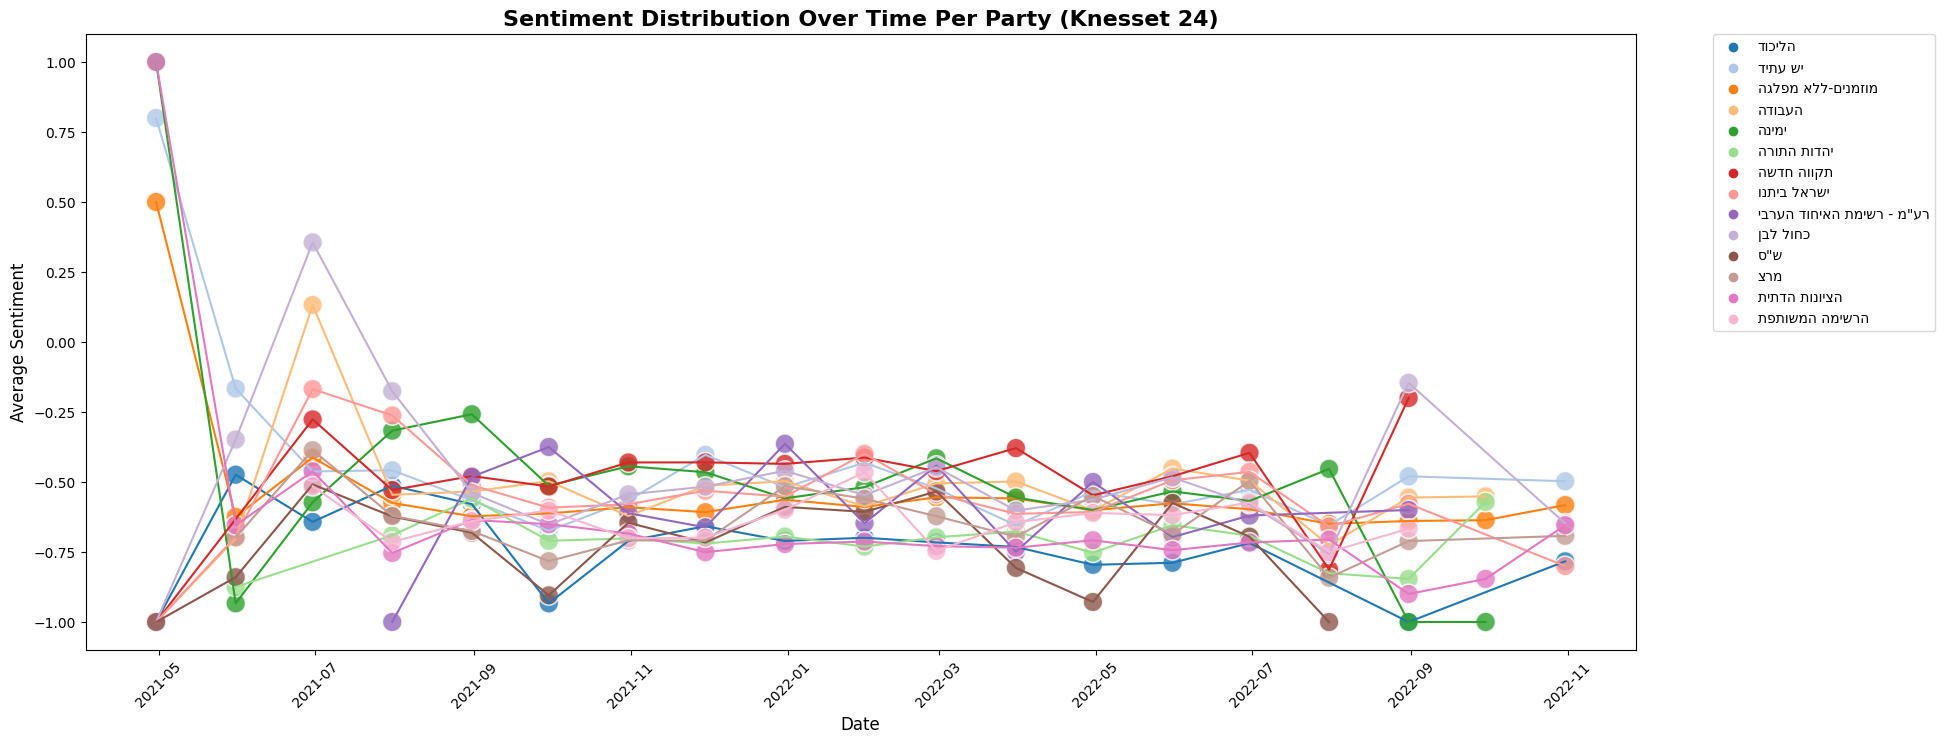

In [ ]:
avg_party_sentiment_time = knesset_df.groupby(['date', knesset_df['party_name'].apply(lambda x: x[::-1])])['sentiment'].mean().reset_index()
avg_party_sentiment_time.drop(avg_party_sentiment_time[avg_party_sentiment_time['date'] == '-1'].index, inplace=True)

avg_party_sentiment_time['date'] = pd.to_datetime(avg_party_sentiment_time['date'], dayfirst=True)

# avg_party_sentiment_time.sort_values(by='date', inplace =True)

# Set 'date' as index before resampling
avg_party_sentiment_time.set_index('date', inplace=True)

# Group by 'committee_type' then resample to compute monthly average sentiment
avg_party_sentiment_time = avg_party_sentiment_time.groupby('party_name').resample('M').mean(numeric_only=True).reset_index()

plt.figure(figsize=(20, 8))

sns.scatterplot(x='date', y='sentiment', hue='party_name', s=200, alpha=0.8, data=avg_party_sentiment_time, palette='tab20')

# Line plot for each party
sns.lineplot(x='date', y='sentiment', hue='party_name', data=avg_party_sentiment_time, palette='tab20', legend=False)

plt.title(f'Sentiment Distribution Over Time Per Party (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Rotate the date labels and reduce the number of labels
plt.xticks(rotation = 45)

# Adjust the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

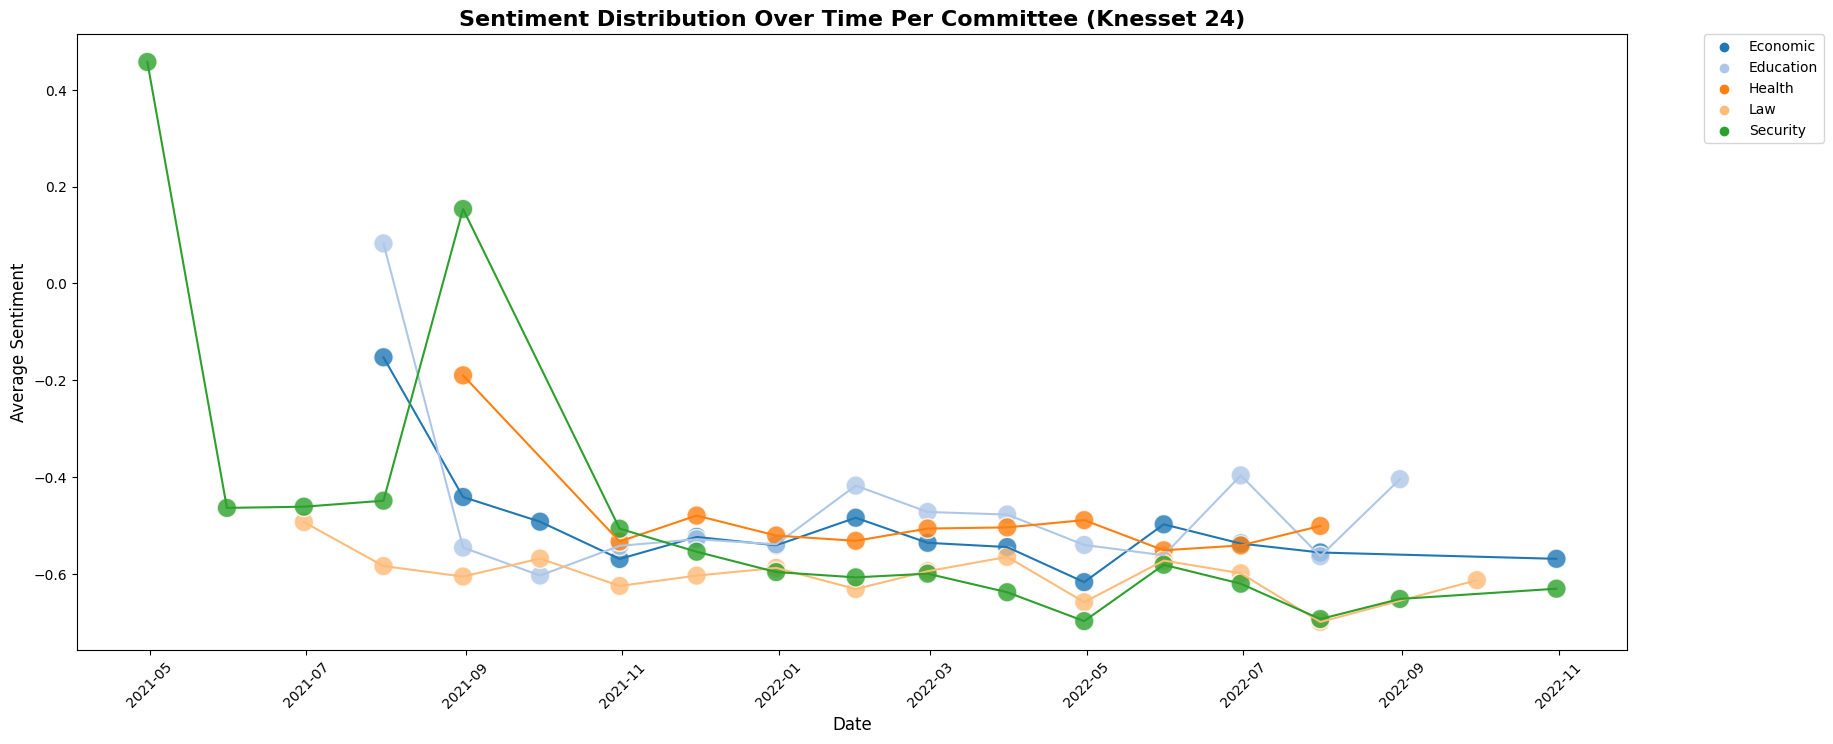

In [ ]:
avg_committee_sentiment_time = knesset_df.groupby(['date', 'committee_type'])['sentiment'].mean().reset_index()
avg_committee_sentiment_time.drop(avg_committee_sentiment_time[avg_committee_sentiment_time['date'] == '-1'].index, inplace=True)
avg_committee_sentiment_time['date'] = pd.to_datetime(avg_committee_sentiment_time['date'], dayfirst=True)

# Set 'date' as index before resampling
avg_committee_sentiment_time.set_index('date', inplace=True)

# Group by 'committee_type' then resample to compute monthly average sentiment
avg_committee_sentiment_time = avg_committee_sentiment_time.groupby('committee_type').resample('M').mean(numeric_only=True).reset_index()

plt.figure(figsize=(20, 8))

sns.scatterplot(x='date', y='sentiment', hue='committee_type', s=200, alpha=0.8, data=avg_committee_sentiment_time, palette='tab20')

# Line plot for each party
sns.lineplot(x='date', y='sentiment', hue='committee_type', data=avg_committee_sentiment_time, palette='tab20', legend=False)

plt.title(f'Sentiment Distribution Over Time Per Committee (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Rotate the date labels and reduce the number of labels
plt.xticks(rotation = 45)

# Adjust the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


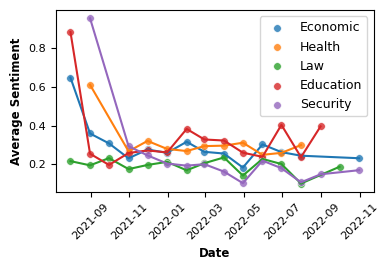

In [ ]:
avg_committee_sentiment_time = knesset_df.groupby(['date', 'committee_type'])['sentiment'].mean().reset_index()
avg_committee_sentiment_time.drop(avg_committee_sentiment_time[avg_committee_sentiment_time['date'] == '-1'].index, inplace=True)
avg_committee_sentiment_time['sentiment'] = 0.8 + avg_committee_sentiment_time['sentiment']

avg_committee_sentiment_time['date'] = pd.to_datetime(avg_committee_sentiment_time['date'], dayfirst=True)
avg_committee_sentiment_time.set_index('date', inplace=True)

committee_list = avg_committee_sentiment_time['committee_type'].unique()

# Change the figure size
plt.figure(figsize=(4, 2.8))

# The rest of your code remains the same
for committee in committee_list:
    if committee == 'Security':
        start_date = '2021-08-01'
    elif committee == 'Economic':
        start_date = '2021-07-01'
    elif committee == 'Education':
        start_date = '2021-07-01'
    elif committee == 'Health':
        start_date = '2021-07-01'
    elif committee == 'Law':
        start_date = '2021-07-01'

    committee_data = avg_committee_sentiment_time[(avg_committee_sentiment_time['committee_type'] == committee) &
                                                  (avg_committee_sentiment_time.index >= start_date)]
    committee_data = committee_data.groupby('committee_type').resample('M').mean(numeric_only=True).reset_index()

    sns.scatterplot(x='date', y='sentiment', label=committee, s=30, alpha=0.8, data=committee_data)
    sns.lineplot(x='date', y='sentiment', data=committee_data, legend=False)

# plt.title(f'Sentiment Distribution Over Time Per Committee (Knesset {knesset_id})', fontsize=10, fontweight='bold')
plt.xlabel('Date', fontsize=8.5, fontweight='bold')
plt.ylabel('Average Sentiment', fontsize=8.5, fontweight='bold')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(fontsize=8)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 6})
plt.legend(loc='upper right', prop={'size': 9}, bbox_to_anchor=(1, 1))

plt.tight_layout()
# plt.savefig('Sentiment Time-Committee.pdf', dpi=300)

plt.show()

### **Party-level Sentiments**

####**Sentiment proportion in different knessets per party:**

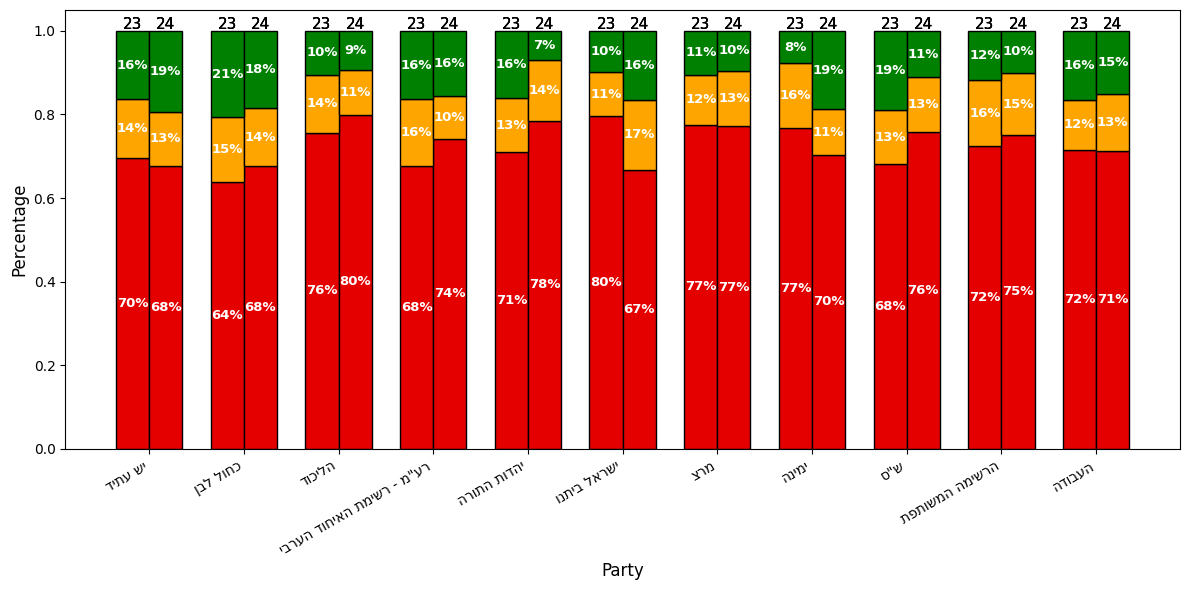

In [ ]:
# Map sentiment scores to categories
sentiment_dict = {-1: 'negative', 0: 'neutral', 1: 'positive'}

df = df[~df['party_name'].isin(['מוזמנים-ללא מפלגה', 'תע"ל – התנועה הערבית להתחדשות', 'תקווה חדשה','הציונות הדתית']) & df['knesset'].isin([23, 24])] # remove parties that are not in both knessets
df.loc[:, 'sentiment_category'] = df['sentiment'].map(sentiment_dict)

# Calculate percentages of sentiment categories for each party
sentiment_percentages = df.groupby([df['party_name'].apply(lambda x: x[::-1]), 'knesset'])['sentiment_category'].value_counts(normalize=True).unstack().fillna(0)

fig, ax = plt.subplots(figsize=(12, 6))
barWidth = 0.35

colors=['#E50000', '#FFA500', '#008000']  # Red for 'negative', orange for 'neutral', green for 'positive'

parties = df['party_name'].apply(lambda x: x[::-1]).unique()

for i, party in enumerate(parties):
    party_data_23 = sentiment_percentages.loc[(party, 23)]
    party_data_24 = sentiment_percentages.loc[(party, 24)]

    for j, sentiment in enumerate(['negative', 'neutral', 'positive']):
        if j == 0:
            ax.bar(i-barWidth/2, party_data_23[sentiment], color=colors[j], width=barWidth, edgecolor='black')
            ax.bar(i+barWidth/2, party_data_24[sentiment], color=colors[j], width=barWidth, edgecolor='black')
        else:
            bottom_23 = sum([party_data_23[sentiment] for sentiment in ['negative', 'neutral'][:j]])
            bottom_24 = sum([party_data_24[sentiment] for sentiment in ['negative', 'neutral'][:j]])
            ax.bar(i-barWidth/2, party_data_23[sentiment], bottom=bottom_23, color=colors[j], width=barWidth, edgecolor='black')
            ax.bar(i+barWidth/2, party_data_24[sentiment], bottom=bottom_24, color=colors[j], width=barWidth, edgecolor='black')

        # Add percentages
        percentage_23 = party_data_23[sentiment]
        percentage_24 = party_data_24[sentiment]
        if sentiment == 'negative':
            ax.text(i-barWidth/2, percentage_23/2, f'{percentage_23:.0%}', ha='center', va='center', fontsize=9.5, color='white', fontweight='bold')
            ax.text(i+barWidth/2, percentage_24/2, f'{percentage_24:.0%}', ha='center', va='center', fontsize=9.5, color='white', fontweight='bold')
        else:
            if percentage_23 > 0.05:  # Only add text if percentage is > 5%
                ax.text(i-barWidth/2, bottom_23+percentage_23/2, f'{percentage_23:.0%}', ha='center', va='center', fontsize=9.5, color='white', fontweight='bold')
            if percentage_24 > 0.05:  # Only add text if percentage is > 5%
                ax.text(i+barWidth/2, bottom_24+percentage_24/2, f'{percentage_24:.0%}', ha='center', va='center', fontsize=9.5, color='white', fontweight='bold')

        # Place text labels
        ax.text(i-barWidth/2, 1.015, '23', ha='center', va='center', fontsize=11)
        ax.text(i+barWidth/2, 1.015, '24', ha='center', va='center', fontsize=11)

ax.set_xticks(range(len(parties)))
ax.set_xticklabels(parties, rotation=30, ha='right')
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Party', fontsize=12)
plt.tight_layout()
# plt.savefig('party sentiment.pdf', dpi=300)
plt.show()

In [ ]:
sentiment_dict = {-1: 'negative', 0: 'neutral', 1: 'positive'}
knesset_df['sentiment_category'] = knesset_df['sentiment'].map(sentiment_dict)

# Calculate percentages of sentiment categories for each party
sentiment_percentages = knesset_df.groupby(knesset_df['party_name'].apply(lambda x: x[::-1]))['sentiment_category'].value_counts(normalize=True).unstack().fillna(0)

# Sort by 'negative' column
sentiment_percentages.sort_values('negative', ascending=True, inplace=True)

# Calculate total occurrences for each party
total_occurrences = knesset_df['party_name'].value_counts()

# Adjust your figure size
# plt.figure(figsize=(10, 10))

# Plot stacked bar chart with a specified figure size
ax = sentiment_percentages.plot(kind='bar', stacked=True, color=['#E50000', '#FFA500', '#008000'], edgecolor = "none", figsize=(14, 6), legend=False)

# Set title and labels
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Party', fontsize=12)
plt.xticks(rotation = 30, fontsize=12, ha="right")

# Set legend outside the plot
# ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})

# Add text annotations for each color in each bar
for i, party in enumerate(sentiment_percentages.index):
    neg = sentiment_percentages.loc[party, 'negative']
    neu = sentiment_percentages.loc[party, 'neutral']
    pos = sentiment_percentages.loc[party, 'positive']
    ax.text(i, neg/2, '{:.0%}'.format(neg), ha='center', va='center', fontsize=9.5, color='white', fontweight='bold')
    ax.text(i, neg + neu/2, '{:.0%}'.format(neu), ha='center', va='center', fontsize=9.5, fontweight='bold')
    ax.text(i, neg + neu + pos/2, '{:.0%}'.format(pos), ha='center', va='center', fontsize=9.5, color='white', fontweight='bold')

# # Add text annotations for total occurrences
# for i, party in enumerate(sentiment_percentages.index):
#     ax.text(i, 0.4, f' Total utterances: {total_occurrences[party[::-1]]}', va='center', rotation=90)

plt.tight_layout()
plt.savefig('party sentiment1.pdf', dpi=300)
plt.show()

# party_name_dict = {'יש עתיד': 'Yesh Atid', 'ש"ס': 'Shas' ,'הליכוד': 'Likud', 'יש עתיד': 'Yesh Atid', 'כחול לבן': 'Blue and White', 'העבודה': 'Labor', 'יש עתיד': 'Yesh Atid', 'יש עתיד': 'Yesh Atid'
# , 'יש עתיד': 'Yesh Atid', 'יש עתיד': 'Yesh Atid', 'יש עתיד': 'Yesh Atid', 'יש עתיד': 'Yesh Atid', 'יש עתיד': 'Yesh Atid'}

<Figure size 800x600 with 0 Axes>

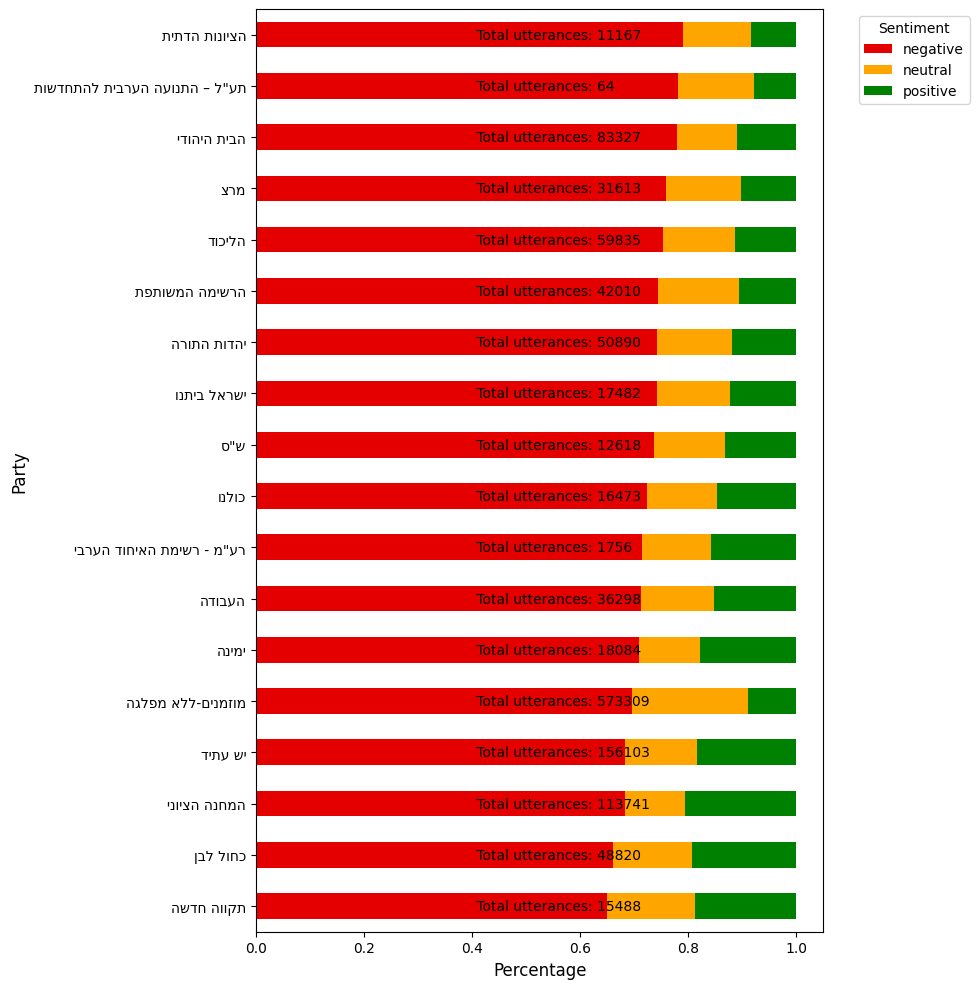

In [ ]:
# Map sentiment values to categories
sentiment_dict = {-1: 'negative', 0: 'neutral', 1: 'positive'}
df['sentiment_category'] = df['sentiment'].map(sentiment_dict)

# Calculate percentages of sentiment categories for each party
sentiment_percentages = df.groupby(df['party_name'].apply(lambda x: x[::-1]))['sentiment_category'].value_counts(normalize=True).unstack().fillna(0)

# Sort by 'negative' column
sentiment_percentages.sort_values('negative', ascending=True, inplace=True)

# Calculate total occurrences for each party
total_occurrences = df['party_name'].value_counts()

# plt.figure(figsize=(8, 6))

# Plot stacked bar chart with a specified figure size
ax = sentiment_percentages.plot(kind='barh', stacked=True, color=['#E50000', '#FFA500', '#008000'], edgecolor = "none", figsize=(10, 10))

# Set title and labels
# plt.title(f'Sentiment distribution per party (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Party', fontsize=12)

# Set legend outside the plot
ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add text annotations for total occurrences
for i, party in enumerate(sentiment_percentages.index):
    ax.text(0.4, i, f' Total utterances: {total_occurrences[party[::-1]]}', va='center')

plt.tight_layout()
plt.show()

####**Sentiment Distribution in different committees per party:**

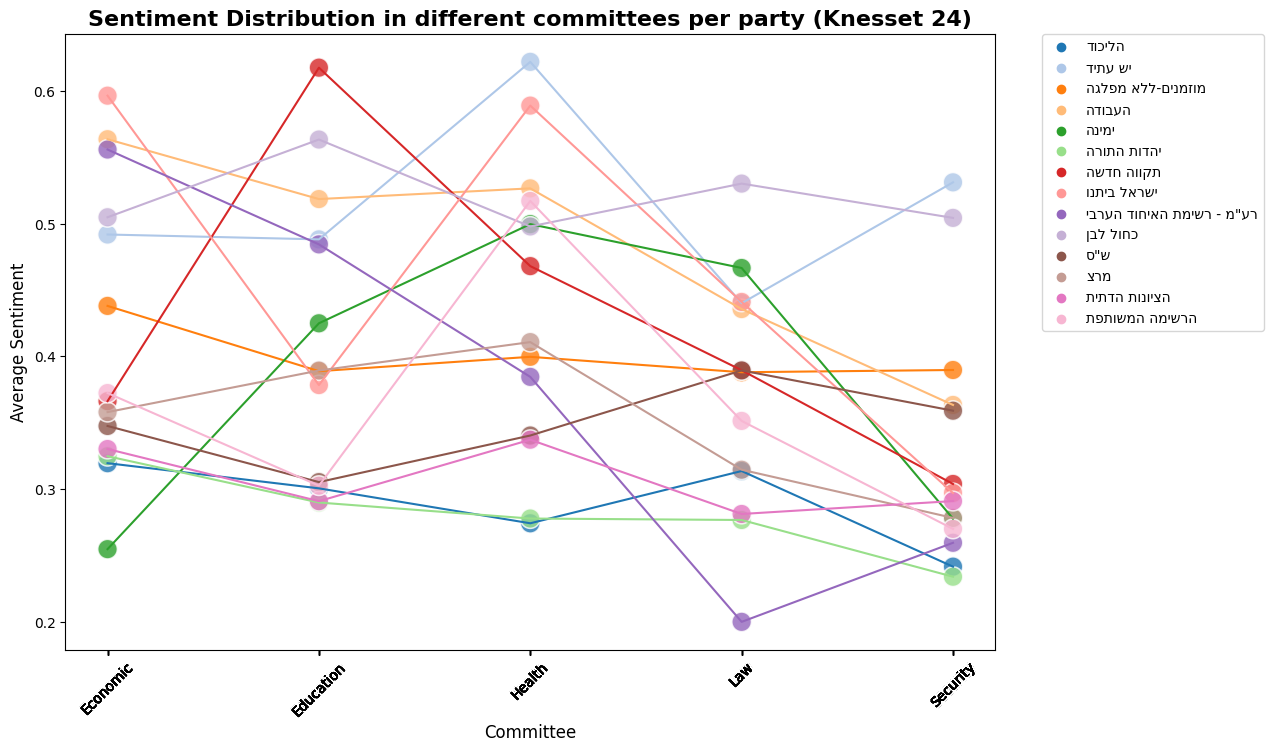

In [ ]:
# Calculate average sentiment for each party and committee type
knesset_df['sentiment'] = knesset_df['sentiment'].astype(float)
party_avg_sentiment = knesset_df.groupby(['committee_type', knesset_df['party_name'].apply(lambda x: x[::-1])])['sentiment'].mean().reset_index()

plt.figure(figsize=(12, 8))
# Subtract 1 from the average sentiment, so the sentiment range will be [0,1] (negative->postive: 0->1)

# Scatter plot for each party
sns.scatterplot(x='committee_type', y=1 + party_avg_sentiment['sentiment'], hue='party_name', s=200, alpha=0.8, data=party_avg_sentiment, palette='tab20')
# Line plot for each party
sns.lineplot(x='committee_type', y=1 + party_avg_sentiment['sentiment'], hue='party_name', data=party_avg_sentiment, palette='tab20', legend=False)

plt.title(f'Sentiment Distribution in different committees per party (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Committee', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Rotate the date labels and reduce the number of labels
plt.xticks(rotation = 45, ticks=party_avg_sentiment['committee_type'])

# Adjust the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Flip the y-axis
# plt.ylim(0, 1)
# plt.yticks(np.arange(0, -1.1, 0.05))


plt.show()

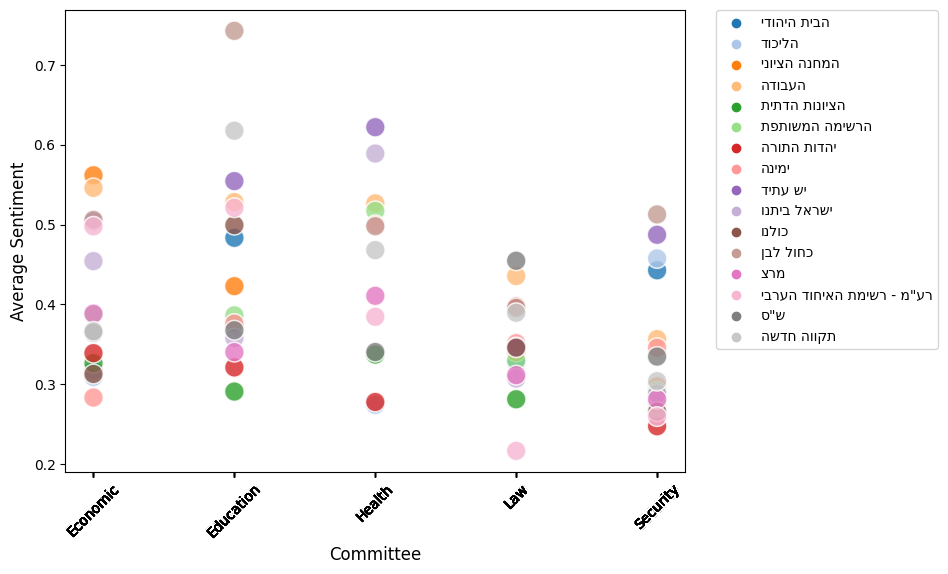

In [ ]:
# Calculate average sentiment for each party and committee type
df['sentiment'] = df['sentiment'].astype(float)
# party_avg_sentiment = df.groupby(['committee_type', df['party_name'].apply(lambda x: x[::-1])])['sentiment'].mean().reset_index()
party_avg_sentiment = df.groupby(['committee_type', 'party_name'])['sentiment'].mean().reset_index()

# Filter out 'Party A' and 'Party B'
party_avg_sentiment = party_avg_sentiment[~party_avg_sentiment['party_name'].isin(['מוזמנים-ללא מפלגה', 'תע"ל – התנועה הערבית להתחדשות'])]
party_avg_sentiment['party_name'] = party_avg_sentiment['party_name'].apply(lambda x: x[::-1])
plt.figure(figsize=(8, 6))
# Subtract 1 from the average sentiment, so the sentiment range will be [0,1] (negative->postive: 0->1)

# Scatter plot for each party
sns.scatterplot(x='committee_type', y= 1 +party_avg_sentiment['sentiment'], hue='party_name', s=200, alpha=0.8, data=party_avg_sentiment, palette='tab20')
# Line plot for each party
# sns.lineplot(x='committee_type', y=1 + party_avg_sentiment['sentiment'], hue='party_name', data=party_avg_sentiment, palette='tab20', legend=False)

# plt.title(f'Sentiment Distribution in different committees per party (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Committee', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)

# Rotate the date labels and reduce the number of labels
plt.xticks(rotation = 45, ticks=party_avg_sentiment['committee_type'])

# Adjust the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Tighten x-axis and spread y-axis


# Flip the y-axis
# plt.ylim(0, 1)
# plt.yticks(np.arange(0, -1.1, 0.05))


plt.show()

#### **Average Sentiment per Committee:**

<Figure size 1200x800 with 0 Axes>

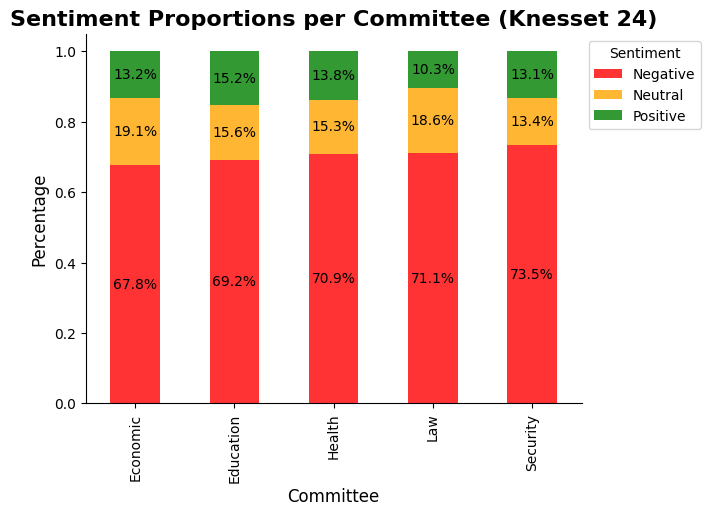

In [ ]:
# Recategorize sentiment as Negative, Neutral and Positive
knesset_df['sentiment_category'] = knesset_df['sentiment'].map({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

# Count the sentiment categories for each committee
sentiment_counts = (
    knesset_df.groupby(['committee_type', 'sentiment_category'])
    .size()
    .unstack(level=-1)
    .fillna(0)
)

# Compute the proportions
sentiment_props = sentiment_counts.divide(sentiment_counts.sum(axis=1), axis=0)

# Define colors for each sentiment category
colors = {'Negative': 'red', 'Neutral': 'orange', 'Positive': 'green'}

# New figure with larger size
plt.figure(figsize=(12, 8))

# Stacked bar plot
ax = sentiment_props.plot(kind='bar', stacked=True, color=[colors[col] for col in sentiment_props.columns], alpha=0.8)

# Rotate x labels if they overlap
plt.xticks(rotation=90)

# Add text annotations for each bar's value
n_col = len(sentiment_props.columns)
for i, (index, row) in enumerate(sentiment_props.iterrows()):
    cumu_height = 0
    for col in range(n_col):
        value = row.iloc[col]
        plt.text(i, cumu_height + value / 2, f"{value*100:.1f}%", ha='center', va='center')
        cumu_height += value

plt.title(f'Sentiment Proportions per Committee (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Committee', fontsize=12)
plt.ylabel('Percentage', fontsize=12)

# Removing top and right borders
sns.despine()

plt.legend(title='Sentiment', bbox_to_anchor=(1,1))

plt.show()

### **Sentiments Analysis- Chairman**

We perform sentiment analysis of these committees and analyze whether the sentiment of the chairman affects the overall distribution of sentiments in the committee.

In [ ]:
# Calculate average sentiment for each party and committee type
knesset_df['sentiment'] = knesset_df['sentiment'].astype(float)
chairman_avg_sentiment = knesset_df.groupby(['protocol_id', 'committee_type', 'is_chairman'])['sentiment'].mean().reset_index()

To assess the significance of the correlation, we conducted a hypothesis test. Specifically, we use a t-test for correlation coefficient significance.

$H_{0} : r = 0$

$H_{a} : r \neq 0$

In this test, the null hypothesis is that the true correlation coefficient is 0 (i.e., there's no correlation with the chairman mean sentiment to the other committee participents), and the alternative hypothesis is that the true correlation coefficient is not equal to 0.

In [ ]:
# Pivot the DataFrame to have separate columns for chairman and non-chairman sentiment
pivot_df = chairman_avg_sentiment.pivot(index=['protocol_id', 'committee_type'], columns='is_chairman', values='sentiment')

# Drop any missing values before computing t-statistic and p-value
pivot_df = pivot_df.dropna()

# Compute correlation
correlation, _ = stats.pearsonr(pivot_df[1], pivot_df[0])


# Compute t-statistic
n = len(pivot_df)
t_statistic = correlation * np.sqrt((n-2) / (1 - correlation**2))

# Compute two-tailed p-value
p_value = stats.t.sf(np.abs(t_statistic), n-2)*2

print("Correlation: ", correlation)
print("p-value: ", p_value)

Correlation:  0.39934323181196085
p-value:  1.2617316835943181e-41


The p-value we got is extremely small, which means the correlation observed is statistically significant under common significance 0.05.

This means we can reject the null hypothesis (that there is no correlation) and conclude that there is a statistically significant correlation between the average sentiment of the chairman and the average sentiment of other parties in the data.

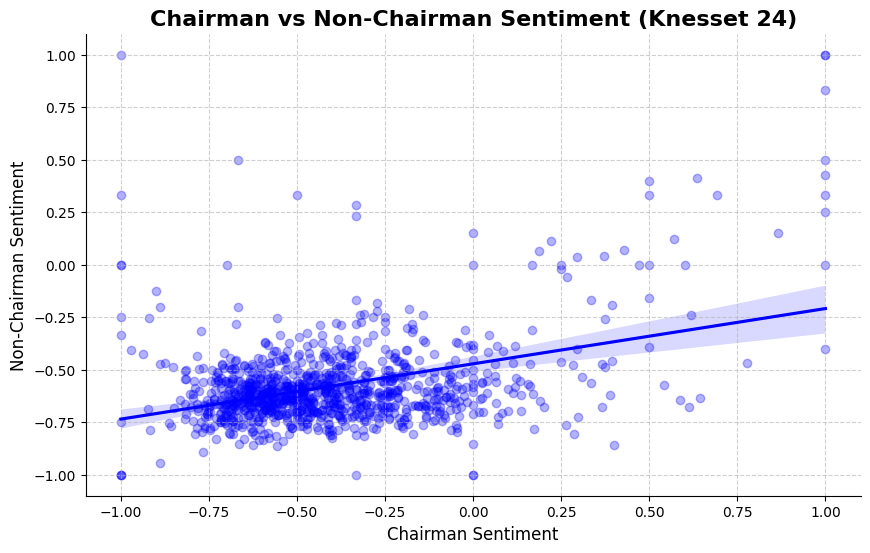

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot with regression line
sns.regplot(x=pivot_df[1], y=pivot_df[0], color='blue', scatter_kws={'alpha':0.3})

# Adding grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.title(f'Chairman vs Non-Chairman Sentiment (Knesset {knesset_id})', fontsize=16, fontweight='bold')
plt.xlabel('Chairman Sentiment', fontsize=12)
plt.ylabel('Non-Chairman Sentiment', fontsize=12)

# Removing top and right borders
sns.despine()

# Show the plot
plt.show()

Next, we test the case where the two groups were determined by whether the permanent chairman was participating in a committee meeting or not. We calculated the average sentiment score of the committee discussions for each group: when the permanent chairman was participating (group 1) and when he wasn't (group 2).

The null hypothesis for the T-Test is that there is no significant difference between the means of the two groups. The p-value resulting from the test indicates the probability that the results occurred by chance given that the null hypothesis is true.

The lower the p-value, the stronger the evidence to reject the null hypothesis in favor of the alternative hypothesis, which posits that there is a significant difference between the means of the two groups. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the means are significantly different.

In our analysis, the p-values calculated provide an indication of whether the sentiment of the discussion was significantly influenced by the presence or absence of the permanent chairman. If a p-value is low (e.g., <0.05), it suggests that the chairman's presence significantly impacted the sentiment of the committee. Conversely, a high p-value (e.g., >0.05) implies that the chairman's presence had no significant effect on the sentiment.

In [ ]:
# # Calculate average sentiment for each party and committee type
# knesset_df['sentiment'] = knesset_df['sentiment'].astype(float)

# # List of chairman and committee pairs
# # Knesset 20
# # chairman_committee_pairs = [
# #     ('איתן כבל', 'Economic'),
# #     ('אבי דיכטר', 'Security'),
# #     ('ניסן סלומינסקי', 'Law'),
# #     ('יעקב מרגי', 'Education')
# # ]

# # Knesset 23
# # chairman_committee_pairs = [
# #     ('יעקב מרגי', 'Economic'),
# #     ('צבי האוזר', 'Security'),
# #     ('יעקב אשר', 'Law'),
# #     ('רם שפע', 'Education')
# # ]

# # Knesset 24
# chairman_committee_pairs = [
#     ('מיכאל מרדכי ביטון', 'Economic'),
#     ('רם בן ברק', 'Security'),
#     ('עידית סילמן', 'Health'),
#     ('גלעד קריב', 'Law'),
#     ('שרן מרים השכל', 'Education')
# ]

# # Prepare lists to hold results
# chairman_names = []
# chairman_parties = []
# committee_names = []
# chairman_sentiments = []
# non_chairman_sentiments = []
# p_values = []
# chairman_protocol_counts = []
# non_chairman_protocol_counts = []

# # Loop over all chairman and committee pairs
# for chairman_name, committee_name in chairman_committee_pairs:
#     # Filter your DataFrame for the specific committee
#     df_committee = knesset_df[knesset_df['committee_type'] == committee_name]

#     # Get protocols where the Permanent chairman is participating
#     chairman_protocols = df_committee[df_committee['member'] == chairman_name]['protocol_id'].unique()

#     # Get the party name of the chairman
#     chairman_party = df_committee.loc[df_committee['member'] == chairman_name, 'party_name'].iloc[0]

#     # Get all unique protocols of the committee
#     all_protocols = df_committee['protocol_id'].unique()

#     # Get protocols where the Permanent chairman is not participating
#     non_participant_protocols = [protocol for protocol in all_protocols if protocol not in chairman_protocols]

#     # Get the sentiment where the chairman is assuming the role
#     chairman_sentiment = df_committee[(df_committee['protocol_id'].isin(chairman_protocols))]['sentiment'].mean()

#     # Get the sentiment where the chairman is not assuming the role
#     non_chairman_sentiment = df_committee[(df_committee['protocol_id'].isin(non_participant_protocols))]['sentiment'].mean()

#     # Count the number of protocols
#     chairman_protocol_count = len(chairman_protocols)
#     non_chairman_protocol_count = len(non_participant_protocols)

#     # Round the average sentiments to three decimal places
#     chairman_sentiment = round(chairman_sentiment, 4)
#     non_chairman_sentiment = round(non_chairman_sentiment, 4)

#     # Create two groups of sentiments: one where the chairman is assuming the role, and one where he is not
#     group1 = df_committee[(df_committee['protocol_id'].isin(chairman_protocols))]['sentiment']
#     group2 = df_committee[(df_committee['protocol_id'].isin(non_participant_protocols))]['sentiment']

#     # Run independent t-test
#     t_stat, p_val = stats.ttest_ind(group1, group2)

#     # Round the p-value to three decimal places
#     p_val = round(p_val, 4)

#     # Append results to lists
#     chairman_names.append(chairman_name)
#     chairman_parties.append(chairman_party)
#     committee_names.append(committee_name)
#     chairman_sentiments.append(chairman_sentiment)
#     non_chairman_sentiments.append(non_chairman_sentiment)
#     p_values.append(p_val)
#     chairman_protocol_counts.append(chairman_protocol_count)
#     non_chairman_protocol_counts.append(non_chairman_protocol_count)

# # Create a DataFrame with the results
# df_results = pd.DataFrame({
#     'Chairman': chairman_names,
#     'Chairman_Party': chairman_parties,
#     'Committee': committee_names,
#     'Chairman_Sentiment': chairman_sentiments,
#     'Non_Chairman_Sentiment': non_chairman_sentiments,
#     'Chairman_Protocol_Count': chairman_protocol_counts,
#     'Non_Chairman_Protocol_Count': non_chairman_protocol_counts,
#     'P-Value': p_values
# })

# # Reshape DataFrame
# df_plot_melt = df_results.melt(id_vars=['Committee', 'P-Value', 'Chairman', 'Chairman_Party', 'Chairman_Protocol_Count', 'Non_Chairman_Protocol_Count'], var_name='Role', value_name='Average Sentiment')

# # Create plot
# plt.figure(figsize=(12,8))
# sns.barplot(data=df_plot_melt, x='Committee', y='Average Sentiment', hue='Role', palette='Set2')
# plt.title(f'Average Sentiment by Committee and parmanent Chairman presence (Knesset {knesset_id})')

# # Annotate p-values, chairman names, chairman parties, and protocol counts
# for i, (p_value, chairman_name, chairman_party, chairman_protocol_count, non_chairman_protocol_count) in enumerate(zip(df_results['P-Value'], df_results['Chairman'].apply(lambda x: x[::-1]), df_results['Chairman_Party'], df_results['Chairman_Protocol_Count'], df_results['Non_Chairman_Protocol_Count'])):
#     plt.text(i, np.max([df_results['Chairman_Sentiment'][i], df_results['Non_Chairman_Sentiment'][i]])-0.2, f'P-Value={p_value}\n({chairman_party}){chairman_name}\nAttended: {chairman_protocol_count}\nNot-Attended: {non_chairman_protocol_count}', ha='center')

# # Adjust the legend
# legend_labels, _= plt.gca().get_legend_handles_labels()
# plt.legend(legend_labels, ['Permanent chairman participate', 'Permanent chairman not participating'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# # Flip the y-axis
# plt.ylim(0, -1)

# plt.show()


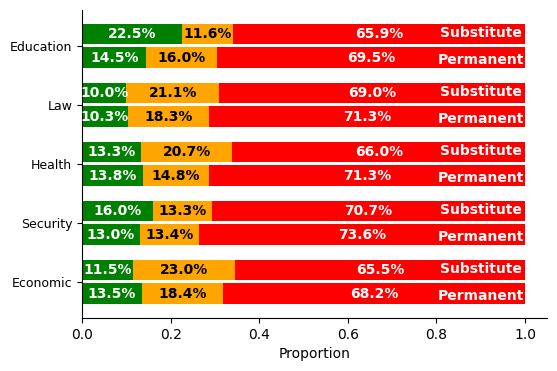

In [ ]:
# Define colors for each sentiment category
colors = {-1: 'red', 0: 'orange', 1: 'green'}

# Knesset 24
chairman_committee_pairs = [
    ('מיכאל מרדכי ביטון', 'Economic'),
    ('רם בן ברק', 'Security'),
    ('עידית סילמן', 'Health'),
    ('גלעד קריב', 'Law'),
    ('שרן מרים השכל', 'Education')
]

# Loop over all chairman and committee pairs
fig, ax = plt.subplots(figsize=(6, 4))

for i, (chairman_name, committee_name) in enumerate(chairman_committee_pairs):
    # Filter your DataFrame for the specific committee
    df_committee = knesset_df[knesset_df['committee_type'] == committee_name]

    # Get the party name of the chairman
    chairman_party = df_committee.loc[df_committee['member'] == chairman_name, 'party_name'].iloc[0]

    # Get protocols where the Permanent chairman is participating
    chairman_protocols = df_committee[df_committee['member'] == chairman_name]['protocol_id'].unique()

    # Get all unique protocols of the committee
    all_protocols = df_committee['protocol_id'].unique()

    # Get protocols where the Permanent chairman is not participating
    non_participant_protocols = [protocol for protocol in all_protocols if protocol not in chairman_protocols]

    # Get the sentiment distribution where the chairman is / is not assuming the role
    chairman_sentiment_counts = df_committee[df_committee['protocol_id'].isin(chairman_protocols)]['sentiment'].value_counts(normalize=True)
    non_chairman_sentiment_counts = df_committee[df_committee['protocol_id'].isin(non_participant_protocols)]['sentiment'].value_counts(normalize=True)

    chairman_sentiment1 = df_committee[df_committee['protocol_id'].isin(chairman_protocols)]['sentiment']
    non_chairman_sentiment1 = df_committee[df_committee['protocol_id'].isin(non_participant_protocols)]['sentiment']

    # Plot stacked bar (horizontal bars) and add the text
    ax.barh(i-0.2, chairman_sentiment_counts.loc[1], color=colors[1], height=0.35, label='Positive' if i == 0 else '')
    ax.text(chairman_sentiment_counts.loc[1]/2, i-0.2, f'{chairman_sentiment_counts.loc[1]*100:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax.barh(i-0.2, chairman_sentiment_counts.loc[0], left=chairman_sentiment_counts.loc[1], color=colors[0], height=0.35, label='Neutral' if i == 0 else '')
    ax.text(chairman_sentiment_counts.loc[1] + chairman_sentiment_counts.loc[0]/2, i-0.2, f'{chairman_sentiment_counts.loc[0]*100:.1f}%', ha='center', va='center', fontweight='bold', fontsize=10)
    ax.barh(i-0.2, chairman_sentiment_counts.loc[-1], left=chairman_sentiment_counts.loc[[1, 0]].sum(), color=colors[-1], height=0.35, label='Negative' if i == 0 else '')
    ax.text(chairman_sentiment_counts.loc[[1, 0]].sum() + chairman_sentiment_counts.loc[-1]/2, i-0.2, f'{chairman_sentiment_counts.loc[-1]*100:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    ax.barh(i+0.2, non_chairman_sentiment_counts.loc[1], color=colors[1], height=0.35)
    ax.text(non_chairman_sentiment_counts.loc[1]/2, i+0.2, f'{non_chairman_sentiment_counts.loc[1]*100:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    ax.barh(i+0.2, non_chairman_sentiment_counts.loc[0], left=non_chairman_sentiment_counts.loc[1], color=colors[0], height=0.35)
    ax.text(non_chairman_sentiment_counts.loc[1] + non_chairman_sentiment_counts.loc[0]/2, i+0.2, f'{non_chairman_sentiment_counts.loc[0]*100:.1f}%', ha='center', va='center', fontweight='bold', fontsize=10)
    ax.barh(i+0.2, non_chairman_sentiment_counts.loc[-1], left=non_chairman_sentiment_counts.loc[[1, 0]].sum(), color=colors[-1], height=0.35)
    ax.text(non_chairman_sentiment_counts.loc[[1, 0]].sum() + non_chairman_sentiment_counts.loc[-1]/2, i+0.2, f'{non_chairman_sentiment_counts.loc[-1]*100:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Run independent t-test
    t_stat, p_val = stats.ttest_ind(chairman_sentiment1, non_chairman_sentiment1)

    # # Add sub x-axis labels
    # ax.text(-0.09, i-0.3, 'Permanent', ha='center')
    # ax.text(-0.09, i+0.2,  'Substitute', ha='center')

    # Add sub x-axis labels
    ax.text(0.9, i-0.3, 'Permanent', ha='center', color='white', fontweight='bold')
    ax.text(0.9, i+0.15,  'Substitute', ha='center', color='white', fontweight='bold')

# Set labels
ax.set_yticks(np.arange(len(chairman_committee_pairs)))
ax.set_yticklabels([pair[1] for pair in chairman_committee_pairs])
ax.set_xlabel('Proportion')
ax.tick_params(axis='y', labelsize=9)
# ax.set_title(f'Sentiment Proportions per Committee and Chairman Presence (Knesset {knesset_id})')
# ax.legend(title='Sentiment', bbox_to_anchor=(1, 1))

# Removing top and right borders
sns.despine()
plt.savefig('chairman sentiment.pdf', dpi=300)
plt.show()


In [ ]:
# import matplotlib.patches as mpatches

# # Knesset 24
# chairman_committee_pairs = [
#     ('מיכאל מרדכי ביטון', 'Economic'),
#     ('רם בן ברק', 'Security'),
#     ('עידית סילמן', 'Health'),
#     ('גלעד קריב', 'Law'),
#     ('שרן מרים השכל', 'Education')
# ]

# # Define colors for each sentiment category
# colors = {-1: 'red', 0: 'orange', 1: 'green'}

# # Loop over all chairman and committee pairs
# fig, ax = plt.subplots(figsize=(15, 10))

# for i, (chairman_name, committee_name) in enumerate(chairman_committee_pairs):
#     # Filter your DataFrame for the specific committee
#     df_committee = knesset_df[knesset_df['committee_type'] == committee_name]

#     # Get the party name of the chairman
#     chairman_party = df_committee.loc[df_committee['member'] == chairman_name, 'party_name'].iloc[0]

#     # Get protocols where the Permanent chairman is participating
#     chairman_protocols = df_committee[df_committee['member'] == chairman_name]['protocol_id'].unique()

#     # Get all unique protocols of the committee
#     all_protocols = df_committee['protocol_id'].unique()

#     # Get protocols where the Permanent chairman is not participating
#     non_participant_protocols = [protocol for protocol in all_protocols if protocol not in chairman_protocols]

#     # Get the sentiment distribution where the chairman is / is not assuming the role
#     chairman_sentiment_counts = df_committee[df_committee['protocol_id'].isin(chairman_protocols)]['sentiment'].value_counts(normalize=True)
#     non_chairman_sentiment_counts = df_committee[df_committee['protocol_id'].isin(non_participant_protocols)]['sentiment'].value_counts(normalize=True)

#     chairman_sentiment1 = df_committee[df_committee['protocol_id'].isin(chairman_protocols)]['sentiment']
#     non_chairman_sentiment1 = df_committee[df_committee['protocol_id'].isin(non_participant_protocols)]['sentiment']

#     # Plot stacked bar (horizontal bars)
#     ax.barh(i-0.2, chairman_sentiment_counts.loc[1], color=colors[1], height=0.35, label='Positive' if i == 0 else '')
#     ax.barh(i-0.2, chairman_sentiment_counts.loc[0], left=chairman_sentiment_counts.loc[1], color=colors[0], height=0.35, label='Neutral' if i == 0 else '')
#     ax.barh(i-0.2, chairman_sentiment_counts.loc[-1], left=chairman_sentiment_counts.loc[[1, 0]].sum(), color=colors[-1], height=0.35, label='Negative' if i == 0 else '')

#     ax.barh(i+0.2, non_chairman_sentiment_counts.loc[1], color=colors[1], height=0.35)
#     ax.barh(i+0.2, non_chairman_sentiment_counts.loc[0], left=non_chairman_sentiment_counts.loc[1], color=colors[0], height=0.35)
#     ax.barh(i+0.2, non_chairman_sentiment_counts.loc[-1], left=non_chairman_sentiment_counts.loc[[1, 0]].sum(), color=colors[-1], height=0.35)

#     # Run independent t-test
#     t_stat, p_val = stats.ttest_ind(chairman_sentiment1, non_chairman_sentiment1)

#     # Annotate p-values, chairman names, chairman parties, and protocol counts
#     ax.text(0.95, i-0.2, f'({chairman_party}){chairman_name[::-1]}\nP-Value: {p_val:.3f}', ha='right', va='center')
#     ax.text(0.5, i+0.2, f'{len(non_participant_protocols)}', ha='center', va='center')
#     ax.text(0.5, i-0.2, f'{len(chairman_protocols)}', ha='center', va='center')

#     # Add sub x-axis labels
#     ax.text(-0.07, i-0.2, 'Chairman Presence', ha='center')
#     ax.text(-0.07, i+0.2,  'No Chairman Presence', ha='center')

# # Set labels
# ax.set_yticks(np.arange(len(chairman_committee_pairs)))
# ax.set_yticklabels([pair[1] for pair in chairman_committee_pairs])
# ax.set_xlabel('Proportion')
# # ax.set_title(f'Sentiment Proportions per Committee and Chairman Presence (Knesset {knesset_id})')
# ax.legend(title='Sentiment', bbox_to_anchor=(1, 1))

# # Removing top and right borders
# sns.despine()

# plt.show()

## **Graph Analysis**

In [ ]:
def df2tree(df: pd.DataFrame) -> dict:
    """ Transforms a pandas dataframe with tree information and converts to tree data type

    Arguments:
        df {pd.DataFrame} -- conversation dataframe

    Returns:
        dict -- dictionary like {'comment_id': anytree.node}
    """
    tree = {x.comment_id: Node(name=x.comment_id, protocol_id=x.protocol_id, committee=x.committee_type, comment_index=x.comment_index,  timestamp=x.date, chairman=x.is_chairman,
                                   author=x.member, party=x.party_name, sentiment=x.sentiment, text=x.text, father=x.parent, parliamentary_group=x.parliamentary_group) for i, x in df.iterrows()}

    # update parents
    for _, v in tree.items():
       v.parent = None if v.father == '-1' else tree[v.father]


    return tree

def load2anytree(df: pd.DataFrame) -> list:

    df = df.filter(['comment_id','protocol_id', 'committee_type', 'date', 'is_chairman', 'member', 'party_name', 'sentiment', 'text', 'parent', 'parliamentary_group'], axis=1)

    df['comment_index'] = df.index
#         logging.info(f'Conversation sample has {df.tree_id.nunique()} unique trees')
#         logging.info(f'Conversation sample has {df.author.nunique()} unique authors')

    # trees_l = list(df.protocol_id)
    # grouped = df[df.protocol_id.isin(trees_l)].groupby(['protocol_id', 'committee_type'])
    grouped = df.groupby(['protocol_id', 'committee_type'])

    all_trees = [df2tree(group) for name, group in grouped]

#     logging.info(f'Done converting {len(all_trees)} conversations to trees')

    return all_trees

In [56]:
knesset_tree = load2anytree(df=knesset_df)

In [50]:
# if knesset 23 use this
# def is_valid_pair(v):
#   return (
#     v.party != v.children[0].party and
#     all(party not in ['מוזמנים-ללא מפלגה','תע"ל – התנועה הערבית להתחדשות','הציונות הדתית'] for party in [v.party, v.children[0].party]) and
#     v.chairman != 1 and
#     v.children[0].chairman != 1
#   )

def is_valid_pair(v):
  return (
    v.party != v.children[0].party and
    all(party not in ['מוזמנים-ללא מפלגה'] for party in [v.party, v.children[0].party]) and
    v.chairman != 1 and
    v.children[0].chairman != 1
  )



def get_interactions_pairs(protocols: list):
    sentiment_dict = {}
    interaction_dict = {}
    pairs = {}
    for protocol in protocols:
       for _, v in protocol.items():
          if v.children:
            if is_valid_pair(v):
               pair = tuple(sorted((v.party, v.children[0].party))) #for undirected graph
              #  pair = tuple((v.party, v.children[0].party)) #for directed graph
               if pair in pairs:
                   pairs[pair].append(v.children[0].sentiment)
               else:
                   pairs[pair] = [v.children[0].sentiment]
    total_interaction = 0
    for pair, sentiments in pairs.items():
        total_weight = len(sentiments)
        weighted_sum = sum(sentiments)
        if total_weight == 0:
            continue  # Skip pairs with no interaction
        elif weighted_sum / total_weight == -1:
            score = 0
        else:
            score = (((weighted_sum / total_weight) + 1) / 2)
        score = round(score, 3)
        sentiment_dict[pair] = score
        interaction_dict[pair] = total_weight
        total_interaction += total_weight

    # print(total_interaction)
    # sorted_pairs_with_scores = [(a, b, s, round((interaction_dict[(a, b)]/total_interaction)*10, 3), round((1-(interaction_dict[(a, b)]/total_interaction)*10), 3)) for ((a, b), s) in sentiment_dict.items()]
    sorted_pairs_with_scores = [(a, b, s, interaction_dict[(a, b)], round((1-(interaction_dict[(a, b)]/total_interaction)*10), 3)) for ((a, b), s) in sentiment_dict.items()]
    sorted_pairs_with_scores.sort(key=lambda x: (x[0], x[1]))

    return sorted_pairs_with_scores

In [57]:
knesset_interactions = get_interactions_pairs(knesset_tree)

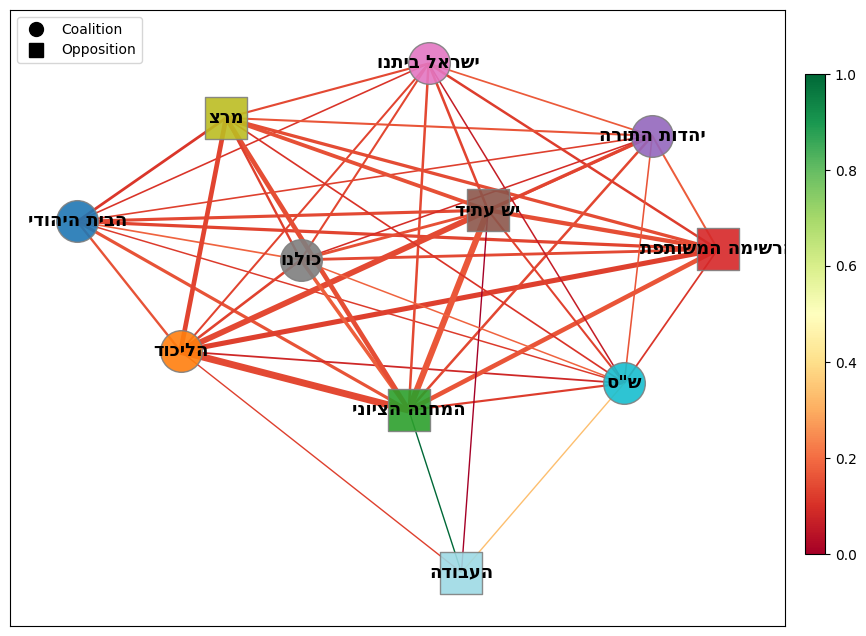

In [58]:
G = nx.Graph() #for undirected graph
# G = nx.DiGraph() #for directed graph

# Add edges with weights (average sentiment score)
for edge in knesset_interactions:
    G.add_edge(edge[0], edge[1], weight=edge[2], interactions=edge[3]) # edge weight by the average sentiment
    # G.add_edge(edge[0], edge[1], weight=edge[3], interactions=edge[3]) # edge weight by the number of interactions
    # G.add_edge(edge[0], edge[1], weight=edge[4], interactions=edge[3]) # edge weight by the inverse of number of interactions

unique_nodes = list(G.nodes())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_nodes)))
color_dict = {}
for i, node in enumerate(unique_nodes):
    color_dict[node] = colors[i]
node_colors = [color_dict[node] for node in G.nodes()]

rev_labels = {}
for node in G.nodes(data=True):
  rev_labels[node[0]] = node[0][::-1]

figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=2022)

# Add legend based on party colors and shapes
patchList = []
options = {"edgecolors": "tab:gray", "node_size": 900, "alpha": 0.9}
for i, node in enumerate(G.nodes(data=True)): # Include node data in the iteration
    shape = 'o' if node[0] in coalition_parties else 's' # Define node shape based on 'parliamentary_group' attribute
    data_key = mpatches.Patch(color=color_dict[node[0]], label=node[0][::-1]) # Add to the legend
    patchList.append(data_key)
    # Draw the nodes one by one with their corresponding shapes and colors
    nx.draw_networkx_nodes(G, pos, nodelist=[node[0]], node_color=[color_dict[node[0]]], node_shape=shape, **options)


edge_weight = nx.get_edge_attributes(G,'weight')

# Scaling interaction weights
interaction_weights = nx.get_edge_attributes(G,'interactions')
scaler = MinMaxScaler(feature_range=(1, 5)) # Range is from 0.1 to 5 to make sure even the smallest edge is visible.
scaled_interaction_weights = scaler.fit_transform(np.array(list(interaction_weights.values())).reshape(-1,1)).flatten()
# scaled_interaction_weights = [w / max(interaction_weights.values()) * 5 for w in interaction_weights.values()] # scale down

# Define color map and normalization
cmap = plt.colormaps.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(edge_weight.values()), vmax=max(edge_weight.values()))
edge_colors = [cmap(norm(w)) for w in edge_weight.values()]

# Draw edges and labels
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=scaled_interaction_weights)
nx.draw_networkx_labels(G, pos, labels=rev_labels, font_size=13, font_weight='bold')

# Don't use edge labels here as it will cover the colors.
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)

# First legend
# legend1 = plt.legend(handles=patchList, loc='upper right')
# plt.gca().add_artist(legend1)

# Create legend for the node shapes
circle_line = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Coalition', linestyle='None')
square_line = mlines.Line2D([], [], color='black', marker='s', markersize=10, label='Opposition', linestyle='None')

# Add second legend
plt.legend(handles=[circle_line, square_line], loc='upper left')

# plt.suptitle(f'All committees interaction graph of {G.number_of_nodes()} parties (Knesset {knesset_id})', fontsize=16, y=0.97)

# Add colorbar to show edge color - sentiment relationship
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# Create custom axes for colorbar
cbar_ax = plt.gcf().add_axes([0.92, 0.2, 0.02, 0.6]) # [left, bottom, width, height]
plt.colorbar(sm, cax=cbar_ax)
plt.savefig('parties interaction graph.pdf', dpi=300)
plt.show()


In [ ]:
G = nx.Graph() #for undirected graph
# G = nx.DiGraph() #for directed graph

# Add edges with weights (average sentiment score)
for edge in knesset_interactions:
    G.add_edge(edge[0], edge[1], weight=edge[2], interactions=edge[3]) # edge weight by the average sentiment
    # G.add_edge(edge[0], edge[1], weight=edge[3], interactions=edge[3]) # edge weight by the number of interactions
    # G.add_edge(edge[0], edge[1], weight=edge[4], interactions=edge[3]) # edge weight by the inverse of number of interactions

unique_nodes = list(G.nodes())
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_nodes)))
color_dict = {}
for i, node in enumerate(unique_nodes):
    color_dict[node] = colors[i]
node_colors = [color_dict[node] for node in G.nodes()]

rev_labels = {}
for node in G.nodes(data=True):
  rev_labels[node[0]] = node[0][::-1]

figure(figsize=(20, 15), dpi=80)
pos = nx.spring_layout(G, seed=2022)

# Add legend based on party colors and shapes
patchList = []
options = {"edgecolors": "tab:gray", "node_size": 900, "alpha": 0.9}
for i, node in enumerate(G.nodes(data=True)): # Include node data in the iteration
    shape = 'o' if node[0] in coalition_parties else 's' # Define node shape based on 'parliamentary_group' attribute
    data_key = mpatches.Patch(color=color_dict[node[0]], label=node[0][::-1]) # Add to the legend
    patchList.append(data_key)
    # Draw the nodes one by one with their corresponding shapes and colors
    nx.draw_networkx_nodes(G, pos, nodelist=[node[0]], node_color=[color_dict[node[0]]], node_shape=shape, **options)


edge_weight = nx.get_edge_attributes(G,'weight')

# Scaling interaction weights
interaction_weights = nx.get_edge_attributes(G,'interactions')
scaler = MinMaxScaler(feature_range=(1, 5)) # Range is from 0.1 to 5 to make sure even the smallest edge is visible.
scaled_interaction_weights = scaler.fit_transform(np.array(list(interaction_weights.values())).reshape(-1,1)).flatten()
# scaled_interaction_weights = [w / max(interaction_weights.values()) * 5 for w in interaction_weights.values()] # scale down

# Define color map and normalization
cmap = plt.colormaps.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(edge_weight.values()), vmax=max(edge_weight.values()))
edge_colors = [cmap(norm(w)) for w in edge_weight.values()]

# Draw edges and labels
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=scaled_interaction_weights)
nx.draw_networkx_labels(G, pos, labels=rev_labels)

# Don't use edge labels here as it will cover the colors.
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_weight)

# First legend
legend1 = plt.legend(handles=patchList, loc='upper right')
plt.gca().add_artist(legend1)

# Create legend for the node shapes
circle_line = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Coalition', linestyle='None')
square_line = mlines.Line2D([], [], color='black', marker='s', markersize=10, label='Opposition', linestyle='None')

# Add second legend
plt.legend(handles=[circle_line, square_line], loc='upper left')

plt.suptitle(f'All committees interaction graph of {G.number_of_nodes()} parties (Knesset {knesset_id})', fontsize=16, y=0.97)

# Add colorbar to show edge color - sentiment relationship
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# Create custom axes for colorbar
cbar_ax = plt.gcf().add_axes([0.92, 0.2, 0.02, 0.6]) # [left, bottom, width, height]
plt.colorbar(sm, cax=cbar_ax)

plt.show()




*   The edges width is according to the number of interaction between the two parties.
*   The edges color is according to the weight(avg sentiment, or number of interaction, or inverse of number of interaction) value between the two parties.
*   The node shape is according to the party parliamentary group(coalition/opposition)



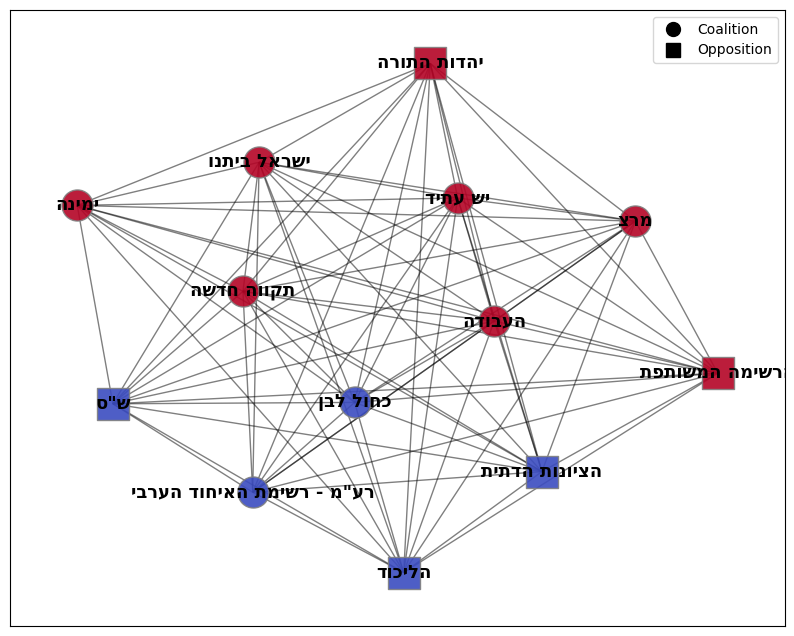

In [ ]:
# compute the best partition
partition = community_louvain.best_partition(G, resolution=1, random_state=42)

# Get a colormap
cmap = plt.cm.coolwarm

plt.figure(figsize=(10,8))
# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
nx.draw_networkx_edges(G, pos, alpha=0.5)
for node, color in partition.items():
    # Normalize the color value (needs to be a float in [0, 1])
    norm_color = [color / max(partition.values())]  # Convert to a one-item list

    # check if the node is in opposition list
    if node in opposition_parties:
        node_shape = 's'  # square
    else:
        node_shape = 'o'  # circle

    nx.draw_networkx_nodes(G, pos, [node], node_size=500,
                           node_color=cmap(norm_color),
                           node_shape=node_shape, edgecolors= 'gray', alpha= 0.9)

# Draw node labels
nx.draw_networkx_labels(G, pos, labels= rev_labels, font_size=13, font_weight='bold')

# Create legend for the node shapes
circle_line = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Coalition', linestyle='None')
square_line = mlines.Line2D([], [], color='black', marker='s', markersize=10, label='Opposition', linestyle='None')

# Add legend
plt.legend(handles=[circle_line, square_line])

# plt.suptitle(f'Louvain Community parties partition (Knesset {knesset_id})', fontsize=16, y=0.97)
plt.savefig('louvain graph.pdf', dpi=300)
plt.show()




*   The color of the nodes is determined automatically based on the partition into communities using the Louvain algorithm.
*   The shape of the nodes is according to the parliamentary affiliation(coalition/opposition) of the parties as it was in practice.



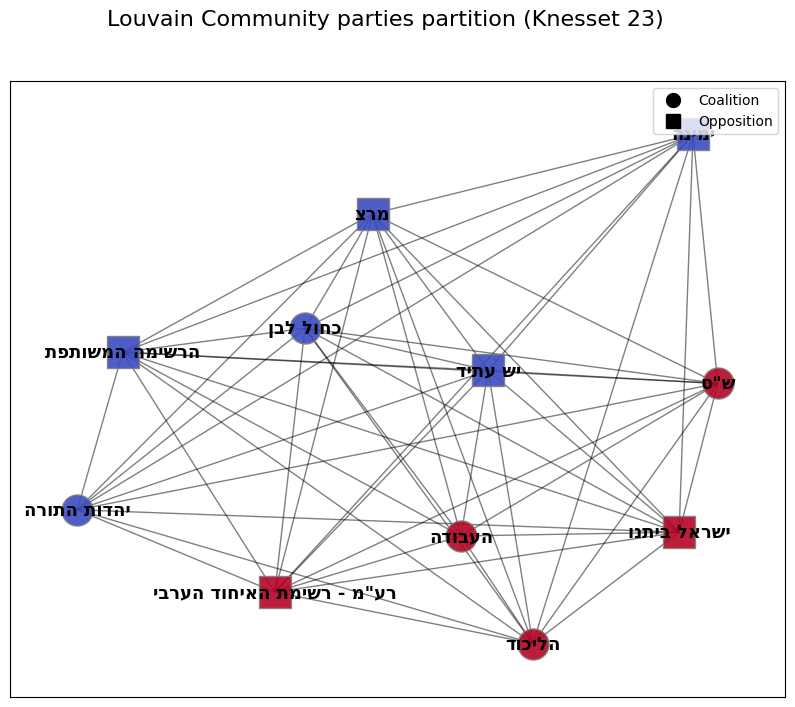

In [46]:
# compute the best partition
partition = community_louvain.best_partition(G, resolution=1, random_state=42)

# Get a colormap
cmap = plt.cm.coolwarm

plt.figure(figsize=(10,8))
# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
nx.draw_networkx_edges(G, pos, alpha=0.5)
for node, color in partition.items():
    # Normalize the color value (needs to be a float in [0, 1])
    norm_color = [color / max(partition.values())]  # Convert to a one-item list

    # check if the node is in opposition list
    if node in opposition_parties:
        node_shape = 's'  # square
    else:
        node_shape = 'o'  # circle

    nx.draw_networkx_nodes(G, pos, [node], node_size=500,
                           node_color=cmap(norm_color),
                           node_shape=node_shape, edgecolors= 'gray', alpha= 0.9)

# Draw node labels
nx.draw_networkx_labels(G, pos, labels= rev_labels, font_size=13, font_weight='bold')

# Create legend for the node shapes
circle_line = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Coalition', linestyle='None')
square_line = mlines.Line2D([], [], color='black', marker='s', markersize=10, label='Opposition', linestyle='None')

# Add legend
plt.legend(handles=[circle_line, square_line])

plt.suptitle(f'Louvain Community parties partition (Knesset {knesset_id})', fontsize=16, y=0.97)
plt.savefig('louvain graph.pdf', dpi=300)
plt.show()

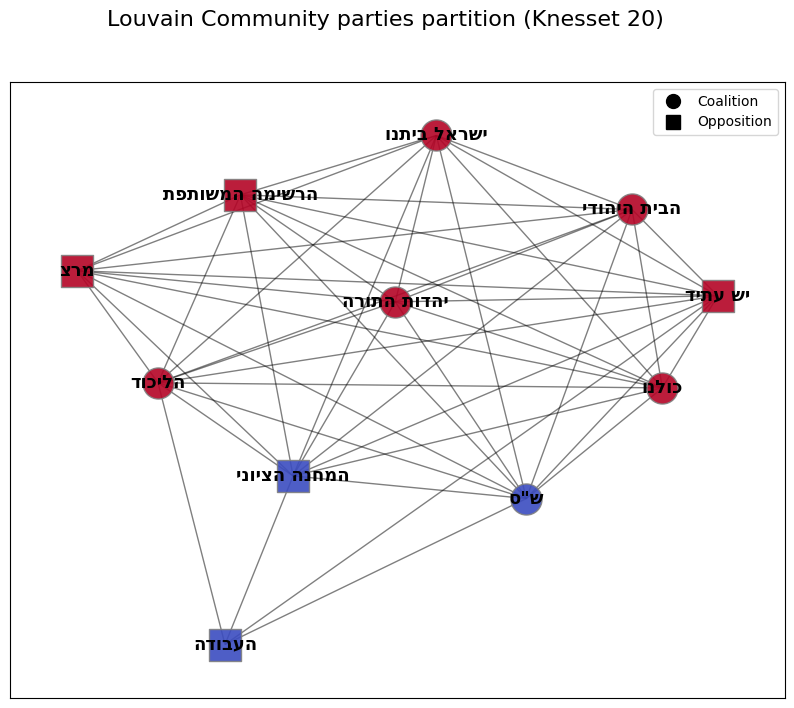

In [65]:
# compute the best partition
partition = community_louvain.best_partition(G, resolution=1, random_state=42)

# Get a colormap
cmap = plt.cm.coolwarm

plt.figure(figsize=(10,8))
# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
nx.draw_networkx_edges(G, pos, alpha=0.5)
for node, color in partition.items():
    # Normalize the color value (needs to be a float in [0, 1])
    norm_color = [color / max(partition.values())]  # Convert to a one-item list

    # check if the node is in opposition list
    if node in opposition_parties:
        node_shape = 's'  # square
    else:
        node_shape = 'o'  # circle

    nx.draw_networkx_nodes(G, pos, [node], node_size=500,
                           node_color=cmap(norm_color),
                           node_shape=node_shape, edgecolors= 'gray', alpha= 0.9)

# Draw node labels
nx.draw_networkx_labels(G, pos, labels= rev_labels, font_size=13, font_weight='bold')

# Create legend for the node shapes
circle_line = mlines.Line2D([], [], color='black', marker='o', markersize=10, label='Coalition', linestyle='None')
square_line = mlines.Line2D([], [], color='black', marker='s', markersize=10, label='Opposition', linestyle='None')

# Add legend
plt.legend(handles=[circle_line, square_line])

plt.suptitle(f'Louvain Community parties partition (Knesset {knesset_id})', fontsize=16, y=0.97)
plt.savefig('louvain graph.pdf', dpi=300)
plt.show()